[View in Colaboratory](https://colab.research.google.com/github/VeereshElango/translator/blob/master/swe_eng_nmt.ipynb)

In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

1.10.1


In [2]:
import requests
import zipfile
# Download the file
def get_data( url, directory ):
  if not os.path.exists(directory):
      os.makedirs(directory)
      filename = url.split("/")[-1]
      with open(directory+filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
      print("File downloaded :",directory+filename)
      extract(directory+filename, directory)
  else:
    print("Data exists")
def extract(path, directory_to_extract_to):
  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(directory_to_extract_to)
  zip_ref.close()
get_data("http://www.manythings.org/anki/swe-eng.zip","./data/")
path_to_file = "./data/swe.txt"

Data exists


In [3]:
import random
with open('./data/swe.txt') as f:
  all_lines = f.readlines()
  print("Total Lines : ",len(all_lines))
  print()
  print("3 Samples\n")
  for i in random.sample(range(1, len(all_lines)), 3):
    print(all_lines[i])

Total Lines :  17300

3 Samples

Do I look tired?	Ser jag trött ut?

Who's your teacher?	Vem är din lärare?

My body isn't as flexible as it used to be.	Min kropp är inte så smidig som den brukade vara.



In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs
  
def max_length(tensor):
    return max(len(t) for t in tensor)


In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):    
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      #print(phrase)
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [0]:
num_examples = 30000


In [7]:
# creating cleaned input, output pairs
pairs = create_dataset(path_to_file, num_examples)
pairs[:5]

[['<start> run ! <end>', '<start> spring ! <end>'],
 ['<start> who ? <end>', '<start> vem ? <end>'],
 ['<start> help ! <end>', '<start> hjalp ! <end>'],
 ['<start> jump ! <end>', '<start> hoppa ! <end>'],
 ['<start> stop ! <end>', '<start> stanna ! <end>']]

In [8]:
# index language using the class defined above    
inp_lang = LanguageIndex(sw for en, sw in pairs)
targ_lang = LanguageIndex(en for en, sw in pairs)
print("Swedish Vocab : ", len(inp_lang.vocab))
print("English Vocab : ", len(targ_lang.vocab))

Swedish Vocab :  6945
English Vocab :  4853


In [0]:
# Swedish sentences
input_tensor = [[inp_lang.word2idx[s] for s in sw.split(' ')] for en, sw in pairs]
    
# English sentences
target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sw in pairs]

In [10]:
for i in random.sample(range(1, len(all_lines)), 3):
  print(pairs[i][1], input_tensor[i])

<start> lat inte den har informationen lacka ut . <end> [5, 3449, 2719, 1054, 2371, 2675, 3348, 6556, 3, 4]
<start> vem kan utfora det har arbetet ? <end> [5, 6801, 2897, 6569, 1070, 2371, 269, 6, 4]
<start> tom bestamde sig for att ringa polisen . <end> [5, 6246, 616, 5194, 1659, 353, 4894, 4623, 3, 4]


In [11]:
# Calculate max_length of input and output tensor
# Here, we'll set those to the longest sentence in the dataset
max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

print("Swedish Maximum length :", max_length_inp)
print("English Maximum length :", max_length_tar)
    

Swedish Maximum length : 34
English Maximum length : 38


In [0]:
# Padding the input and output tensor to the maximum length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')

In [13]:
for i in random.sample(range(1, len(all_lines)), 3):
  print(pairs[i][1])
  print(input_tensor[i])

<start> le inte . <end>
[   5 3469 2719    3    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
<start> att ata en klyfta vitlok varje dag , ar det nyttigt for dig ? <end>
[   5  353  324 1301 3052 6904 6742  984    2  260 1070 4160 1659 1078
    6    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
<start> borde vi inte saga nagonting ? <end>
[   5  797 6828 2719 5014 4021    6    4    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(13840, 13840, 3460, 3460)

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
print("N_BATCH :",N_BATCH)
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
print(dataset)
dataset = dataset.shuffle(BUFFER_SIZE)
print(dataset)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

N_BATCH : 216
<TensorSliceDataset shapes: ((34,), (38,)), types: (tf.int32, tf.int32)>
<ShuffleDataset shapes: ((34,), (38,)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 34), (64, 38)), types: (tf.int32, tf.int32)>


In [0]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [20]:
print(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

6946 256 1024 64


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [22]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    #Every epoch, hidden state is initialized
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    #print(dataset)
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        #print("Batch : ",batch, " Input : ",inp.shape, " Target : ", targ.shape)
        
        with tf.GradientTape() as tape:#what is gradient tape ?
            enc_output, enc_hidden = encoder(inp, hidden)
            
            #print("Enc Output :",enc_output.shape)
            #print("Enc Hidden :",enc_hidden.shape)
            
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5421
Epoch 1 Batch 100 Loss 0.8490
Epoch 1 Batch 200 Loss 0.5946
Epoch 1 Loss 0.8230
Time taken for 1 epoch 216.463449716568 sec

Epoch 2 Batch 0 Loss 0.5398
Epoch 2 Batch 100 Loss 0.5837
Epoch 2 Batch 200 Loss 0.4963
Epoch 2 Loss 0.5312
Time taken for 1 epoch 216.44912385940552 sec

Epoch 3 Batch 0 Loss 0.3902
Epoch 3 Batch 100 Loss 0.4200
Epoch 3 Batch 200 Loss 0.3195
Epoch 3 Loss 0.3856
Time taken for 1 epoch 215.2748908996582 sec

Epoch 4 Batch 0 Loss 0.2476
Epoch 4 Batch 100 Loss 0.2922
Epoch 4 Batch 200 Loss 0.3264
Epoch 4 Loss 0.2830
Time taken for 1 epoch 216.2699179649353 sec

Epoch 5 Batch 0 Loss 0.1770
Epoch 5 Batch 100 Loss 0.2226
Epoch 5 Batch 200 Loss 0.2049
Epoch 5 Loss 0.2064
Time taken for 1 epoch 215.92960929870605 sec

Epoch 6 Batch 0 Loss 0.1447
Epoch 6 Batch 100 Loss 0.1324
Epoch 6 Batch 200 Loss 0.1823
Epoch 6 Loss 0.1635
Time taken for 1 epoch 215.81836652755737 sec

Epoch 7 Batch 0 Loss 0.1205
Epoch 7 Batch 100 Loss 0.1193
Epoch 7 Batch 20

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [26]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> ser jag trott ut ? <end>
Predicted translation: do i look tired ? <end> 


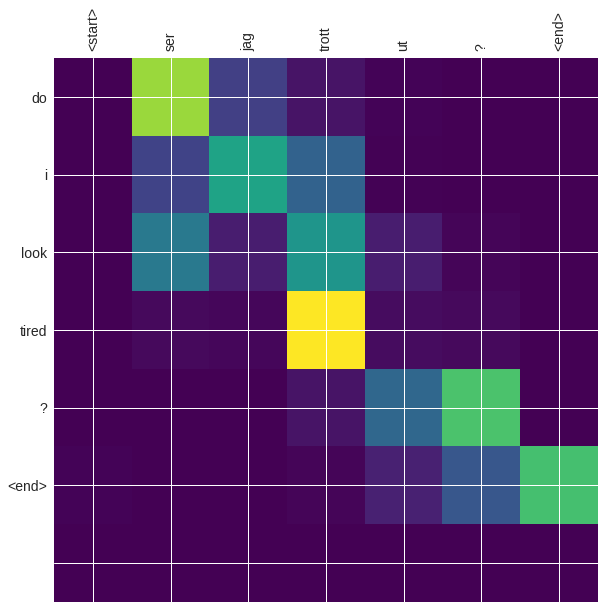

In [29]:
translate('Ser jag trött ut?', encoder, decoder, inp_lang, targ_lang, max_length_inp, 38)

Input: <start> han alskar fotboll . <end>
Predicted translation: he loves soccer . <end> 


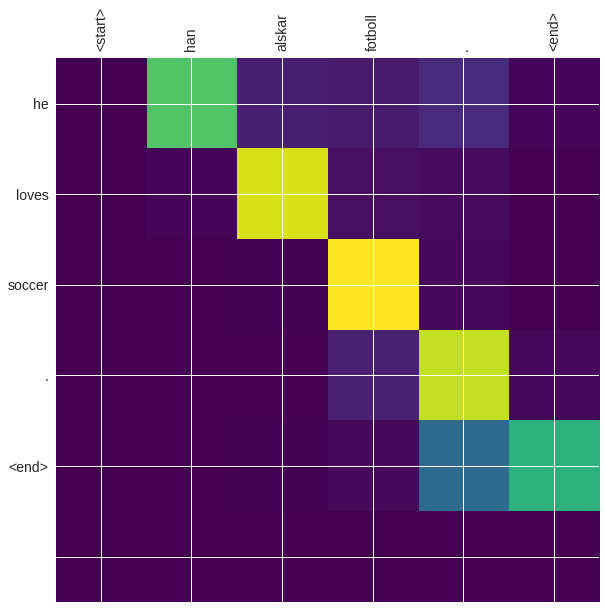

In [30]:
translate('Han älskar fotboll.', encoder, decoder, inp_lang, targ_lang, max_length_inp, 38)